# GAN Example

## Generating Training Data

Implement our true dataset by generating random samples using numpy library and then generating the second coordinate using some kind of function. For the purpose of this demo, we have kept the function as a quadratic function for simplicity.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Define a quadratic function computes the value y = 10 + x**2 to produce real samples
def get_y(x):
    return 10 + x*x

def sample_data(n = 10000, scale = 100):
    data = []

    x = scale * (np.random.random_sample((n,)) -0.5)

    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])

    return np.array(data)

# Defines a function to generate random noise
def sample_Z(m,n):
    return np.random.uniform(-1., 1., size = [m,n])

Plotting the data

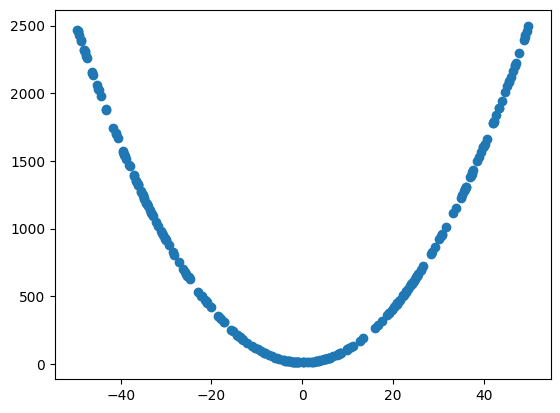

In [3]:
data = sample_data(n= 256)

plt.scatter(data[:,0], data[:,1])

## Generator and Discriminator Networks Implementation

We will now implement the Generator and Discriminator networks using tensorflow layers.

In [4]:
def generator(Z, hsize = [16, 16], reuse = False):
    """ 
    Inputs: Z - placeholder for random input samples, hsize - List defining the number of units in hidden layers
    reuse - Boolean to reuse the same layers

    Layers: h1 - first hidden layer with leaky ReLU activation, h2- second hidden layer with leaky ReLU activation
    out - output layer generating a 2D vector

    This function creates a fully connected neural network with two hidden layers and outputs a 2D vector, 
    matching the dimensions of the real dataset. The goal is for the generator to learn the distribution of the real data.
    """
    with tf.compat.v1.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.keras.layers.Dense(hsize[0], activation=tf.nn.leaky_relu)(Z)
        h2 = tf.keras.layers.Dense(hsize[1], activation=tf.nn.leaky_relu)(h1)
        out = tf.keras.layers.Dense(2)(h2)

    return out

In [5]:
def discriminator(X, hsize = [16, 16], reuse = False):
    """ 
    Inputs: X - placeholder for input samples (real or generated), hsize - List defining the number of units in hidden layers
    reuse - Boolean to reuse the same layers

    Layers: h1 - first hidden layer with leaky ReLU activation, h2- second hidden layer with leaky ReLU activation,
    h3: Third hidden layer, fixed to 2 units for 2D visualization, out - Output layer generating a logit prediction.

    The discriminator evaluates whether the input samples are real or generated. The output consists of 
    logit prediction: indicates the probability of the input being real and h3 Output: Feature transformation learned by the discriminator, 
    useful for visualization
    """
    with tf.compat.v1.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.keras.layers.Dense(hsize[0], activation=tf.nn.leaky_relu)(X)
        h2 = tf.keras.layers.Dense(hsize[1], activation=tf.nn.leaky_relu)(h1)
        h3 = tf.keras.layers.Dense(2)(h2)
        out = tf.keras.layers.Dense(1)(h3)

    return out, h3

## Adversarial training

For the purpose of training we define the following placeholders X and Z for real samples and random noise samples respectively

In [6]:
tf.compat.v1.disable_eager_execution() 

X = tf.compat.v1.placeholder(tf.float32, [None,2]) # X: Placeholder for real samples, where each sample is a 2D vector.
Z = tf.compat.v1.placeholder(tf.float32, [None,2]) # Z: Placeholder for random noise samples, where each sample is also a 2D vector.

We also need to create the graph for generating samples from Generator network and feeding real and generated samples to the Discriminator network. This is done by using the functions and placeholders defined above:

In [7]:
"""
G_sample : Output from the Generator network, generated from random noise (Z)
r_logits : Logit predictions for real samples X
r_rep : Feature representation from the Discriminator for real samples.
f_logits : Logit predictions for generated samples G_sample
g_rep : Feature representation from the Discriminator for generated samples

This set up creates a computational graph where:

** The Generator creates fake samples from random noise.
** The Discriminator evaluates both real and fake samples.
** The Discriminator's parameters are reused to ensure consistent training.
"""

# Generate samples from the Generator network
G_sample = generator(Z)

# Get logits and feature representation for real samples from the Discriminator network
r_logits, r_rep = discriminator(X)

# Get logits and feature representation for generated samples, reusing the Discriminator network
f_logits, g_rep = discriminator(G_sample, reuse = True)

Using the logits for generated data and real data we define the loss functions for the Generator and Discriminator networks as follows:

In [8]:
"""
Discriminator loss: 
- Compares real samples' logits (r_logits) to a tensor of ones (indicating real samples).
- Compares generated samples' logits (f_logits) to a tensor of zeros (indicating fake samples).
- The mean of both losses represents how well the Discriminator distinguishes real from fake samples.

Generator loss:
- Compares generated samples' logits (f_logits) to a tensor of ones 
(indicating the Generator's goal to fool the Discriminator into thinking the samples are real).
-  The mean of this loss measures how well the Generator fools the Discriminator.
"""
# Discriminator Loss
disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = r_logits, labels = tf.ones_like(r_logits))+ 
                           tf.nn.sigmoid_cross_entropy_with_logits(logits = f_logits, labels = tf.zeros_like(f_logits)))

# Generator Loss
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = f_logits, labels = tf.ones_like(f_logits)))

These losses are sigmoid cross entropy based losses.  It takes as input the logit (which is given by our discriminator network) and true labels for each sample. It then calculates the error for each sample.

Next, we define the optimizers for the two networks using the loss functions defined above and scope of the layers defined in the generator and discriminator functions. We use RMSProp Optimizer for both the networks with the learning rate as 0.001. Using the scope we fetch the weights/variables for the given network only.

In [9]:
"""
Purpose: Optimizers are crucial for updating the network weights to minimize the loss functions.
By specifying the var_list, we ensure that each optimizer only updates the variables of the respective network.

This setup allows the GAN to train both networks in an adversarial manner, 
improving the Generator's ability to create realistic data and the Discriminator's ability to distinguish real from fake data.
"""
# Fetch variables for Generator and Discriminator
gen_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope = "GAN/Generator")
disc_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope = "GAN/Discriminator")

# Define RMSProp Optimizer for both networks
gen_step = tf.compat.v1.train.RMSPropOptimizer(learning_rate = 0.001).minimize(gen_loss, var_list = gen_vars) # G Train step
disc_step = tf.compat.v1.train.RMSPropOptimizer(learning_rate = 0.001).minimize(disc_loss, var_list = disc_vars) # D Train step



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


We then train both the networks in an alternating way for the required number of steps:

In [10]:
sess = tf.compat.v1.Session()
tf.compat.v1.global_variables_initializer().run(session = sess)

batch_size = 256


In [11]:
# Change number of iterations accordingly
for i in range(1001):
    # Generate a batch of real samples
    X_batch = sample_data( n = batch_size)
    # Genrate a batch of random noise samples
    Z_batch = sample_Z(batch_size, 2)

    # Train the Discriminator
    _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})

    # Train the Generator
    _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

    """
    In the event of too many iterations use this code:
    if i % 1000 == 0:  # Print every 1000 iterations
        print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f" % (i, dloss, gloss))
    """

    # Print iteration number, Discriminator loss, and Generator loss
    print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f" % (i, dloss, gloss))

Iterations: 0	 Discriminator loss: 0.6949	 Generator loss: 0.6930
Iterations: 1	 Discriminator loss: 0.6946	 Generator loss: 0.6936
Iterations: 2	 Discriminator loss: 0.6941	 Generator loss: 0.6940
Iterations: 3	 Discriminator loss: 0.6926	 Generator loss: 0.6952
Iterations: 4	 Discriminator loss: 0.6920	 Generator loss: 0.6959
Iterations: 5	 Discriminator loss: 0.6917	 Generator loss: 0.6965
Iterations: 6	 Discriminator loss: 0.6908	 Generator loss: 0.6972
Iterations: 7	 Discriminator loss: 0.6895	 Generator loss: 0.6986
Iterations: 8	 Discriminator loss: 0.6890	 Generator loss: 0.6992
Iterations: 9	 Discriminator loss: 0.6884	 Generator loss: 0.6999
Iterations: 10	 Discriminator loss: 0.6874	 Generator loss: 0.7009
Iterations: 11	 Discriminator loss: 0.6866	 Generator loss: 0.7018
Iterations: 12	 Discriminator loss: 0.6862	 Generator loss: 0.7030
Iterations: 13	 Discriminator loss: 0.6846	 Generator loss: 0.7040
Iterations: 14	 Discriminator loss: 0.6839	 Generator loss: 0.7049
Itera

In [12]:
"""
nd_steps = 10
ng_steps = 10

x_plot = sample_data(n=batch_size)
# Train the discriminator
    for _ in range (nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict = {X: X_batch, Z: Z_batch})
        rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict = {X: X_batch, Z: Z_batch})

    # Train the generator
    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict = {Z: Z_batch})
        rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict = {X: X_batch, Z: Z_batch})

    print ("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))

    if i%1000 == 0:
        plt.figure()
        g_plot = sess.run(G_sample, feed_dict = {Z: Z_batch})
        xax = plt.scatter(x_plot[:,0], x_plot[:,1])
        gax = plt.scatter(g_plot[:,0], g_plot[:,1])

        plt.legend((xax, gax), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
        plt.tight_layout()

        plt.figure()
        rrd = plt.scatter(rrep_dstep[:,0], rrep_dstep[:,1], alpha = 0.5)
        rrg = plt.scatter(rrep_dstep[:,0], rrep_dstep[:,1], alpha = 0.5)
        grd = plt.scatter(rrep_dstep[:,0], rrep_dstep[:,1], alpha = 0.5)
        grg = plt.scatter(rrep_dstep[:,0], rrep_dstep[:,1], alpha = 0.5)

        plt.legend((rrd, rrg, grd, grg), ("Real Data Before G step","Real Data After G step",
                   "Generated Data Before G step","Generated Data After G step"))
        plt.title('Transformed Features at Iteration %d'%i)
        plt.tight_layout()

        plt.figure()

        rrdc = plt.scatter(np.mean(rrep_dstep[:,0]), np.mean(rrep_dstep[:,1]),s=100, alpha=0.5)
        rrgc = plt.scatter(np.mean(rrep_gstep[:,0]), np.mean(rrep_gstep[:,1]),s=100, alpha=0.5)
        grdc = plt.scatter(np.mean(grep_dstep[:,0]), np.mean(grep_dstep[:,1]),s=100, alpha=0.5)
        grgc = plt.scatter(np.mean(grep_gstep[:,0]), np.mean(grep_gstep[:,1]),s=100, alpha=0.5)

        plt.legend((rrdc, rrgc, grdc, grgc), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))
        
        plt.title('Centroid of Transformed Features at Iteration %d'%i)
        plt.tight_layout
"""

'\nnd_steps = 10\nng_steps = 10\n\nx_plot = sample_data(n=batch_size)\n# Train the discriminator\n    for _ in range (nd_steps):\n        _, dloss = sess.run([disc_step, disc_loss], feed_dict = {X: X_batch, Z: Z_batch})\n        rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict = {X: X_batch, Z: Z_batch})\n\n    # Train the generator\n    for _ in range(ng_steps):\n        _, gloss = sess.run([gen_step, gen_loss], feed_dict = {Z: Z_batch})\n        rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict = {X: X_batch, Z: Z_batch})\n\n    print ("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))\n\n    if i%1000 == 0:\n        plt.figure()\n        g_plot = sess.run(G_sample, feed_dict = {Z: Z_batch})\n        xax = plt.scatter(x_plot[:,0], x_plot[:,1])\n        gax = plt.scatter(g_plot[:,0], g_plot[:,1])\n\n        plt.legend((xax, gax), ("Real Data","Generated Data"))\n        plt.title(\'Samples at Iteration %d\'%i)\n        plt.tight_la